**Introducción**:

*Los modelos predictivos en el ámbito del machine learning representan una herramienta invaluable para el análisis y la mejora continua de las operaciones empresariales. En particular, en este proyecto centrado en el sector de las tarjetas de crédito, se explorará la aplicación de técnicas predictivas para evaluar la probabilidad de abandono de clientes del banco. A través de la identificación de patrones significativos en los datos, se buscará comprender mejor el comportamiento de los clientes y anticipar sus posibles acciones. Posteriormente, se implementarán medidas estratégicas con el fin de mitigar estos riesgos y fomentar la **retención de clientes**. Este enfoque no solo busca optimizar la rentabilidad del negocio, sino también fortalecer la relación con los clientes al ofrecer soluciones personalizadas y proactivas.*

- **Medida elegida:** *La precisión* *en problemas de clasificación indica qué tan exacto es un modelo en predecir la clase correcta. Optimizarla nos ayudará a mejorar la confiabilidad de nuestras predicciones, lo que es crucial para la optimización de recursos y satisfacción del cliente.*

*La precisión en este caso sería la medida de cuántos de los clientes que el modelo predice que van a abandonar, realmente lo hacen. Por ejemplo, si el modelo predice que 100 clientes abandonarán el banco y 85 de ellos realmente lo hacen, la precisión sería del 85%.* 

**Una alta precisión aquí significa que el banco puede identificar con confianza a la mayoría de los clientes propensos a abandonarlo, permitiéndoles tomar medidas proactivas para retenerlos**.*

<br>

<div style="text-align:center;">
    <img src="img\precision.jpg" alt="Texto alternativo" width=500px >
</div>

### **Librerías**

In [2]:
### Manipulación de Datos
import pandas as pd
import numpy as np

### Visualización de Datos
import seaborn as sns
import matplotlib.pyplot as plt

### Tratamiento de datos con funciones personalizadas
from utils.funciones import extended_describe, BaseLine

### Machine Learning

# Preparación de datos 
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import BorderlineSMOTE, ADASYN, SMOTENC, SMOTE
from sklearn.decomposition import PCA

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  RandomForestClassifier,  GradientBoostingClassifier, VotingClassifier,  AdaBoostClassifier, StackingClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Métricas
from sklearn.metrics import  classification_report, confusion_matrix,  precision_recall_curve, roc_curve, roc_auc_score,  make_scorer, f1_score
from sklearn.model_selection import GridSearchCV

# Guardado de modelos
import pickle

# Ignorar warnings
import warnings
warnings.filterwarnings('ignore')

# DATOS previamente procesados y analizados
df = pd.read_csv('./data/processed/Churn_Modelling.csv')

### **Modelo 1**
**Sin feature enginering y con OneHotEncoder**

*Antes de iniciar cualquier análisis de datos, es crucial comprender la estructura y la naturaleza de los datos en su forma original. Esto proporciona una base sólida para evitar errores comunes, como el sobreajuste y la mala interpretación de los resultados. Es esencial establecer una referencia clara de cómo se reciben los datos inicialmente, ya que cualquier manipulación posterior podría influir en los resultados finales.*

In [50]:
df = pd.read_csv('./data/processed/Churn_Modelling.csv')
df.drop(columns=['RowNumber', 'CustomerId', 'Surname',], inplace=True)

# Definir las variables X e y
X = df.drop(columns=['Exited'])
y = df['Exited']

numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
variables_sin_modificacion = ['HasCrCard', 'IsActiveMember']
categorical_features = ['Geography', 'Gender']

# Definir transformadores para características numéricas y categóricas
numeric_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder()

# Crear un ColumnTransformer para aplicar transformaciones a diferentes columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Crear el pipeline con el preprocesador
pipeline = make_pipeline(preprocessor)
# Aplicar el preprocesador a los datos
X_processed = pipeline.fit_transform(X)

# Obtener los nombres de las columnas después de aplicar OneHotEncoder
encoded_categorical_columns = preprocessor.named_transformers_['cat']\
    .get_feature_names_out(input_features=categorical_features)

# Combinar los nombres de las columnas numéricas y categóricas
processed_columns = numeric_features + list(encoded_categorical_columns)

# Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df = pd.DataFrame(X_processed, columns=processed_columns)
concatenated_series  = pd.concat((processed_df, X[[ 'HasCrCard', 'IsActiveMember']]), axis=1)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(concatenated_series, y, test_size=0.2, random_state=24)

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=24)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

model_1_Baseline = BaseLine(X_train_resampled, y_train_resampled, cv=5, metricas_cross_validate= ['accuracy', 'recall_macro', 'precision_macro']) # Realizar un baseline -> input = todos
model_1_Baseline

Metrica,accuracy,precision,recall
Modelo,,,
ADABoosting,0.823562,0.826983,0.823554
CatBoost,0.890462,0.910719,0.890442
Decision Tree,0.833915,0.842016,0.833900
Extra Trees,0.823873,0.825469,0.823870
Gradient Boosting,0.858383,0.866184,0.858369
HistGradientBoost,0.883167,0.899074,0.883148
KNN,0.835634,0.849602,0.835633
LGBM,0.885914,0.906152,0.885893
Logistic Regression,0.707575,0.707786,0.707572


*La mayoría de nuestros datos se ajustan adecuadamente según la **media** obtenida mediante la validación cruzada. Esta técnica implica dividir el conjunto de datos en múltiples subconjuntos, alternando entre ellos para entrenar y evaluar el modelo. La media de las métricas de rendimiento proporciona una evaluación más robusta del modelo, ya que no depende de una sola división de los datos. Es importante recordar que los valores en el conjunto de datos son aproximados y redondeados, lo que facilita la aplicación de modelos y la selección de los más adecuados.*

*La **validación cruzada** es esencial para evaluar la capacidad de generalización de un modelo. Consiste en dividir el conjunto de datos en K subconjuntos (llamados "folds"), donde uno de los subconjuntos se reserva como conjunto de prueba y los restantes se utilizan como conjunto de entrenamiento. Este proceso se repite K veces, de manera que cada subconjunto se utilice como conjunto de prueba exactamente una vez. Finalmente, se promedian los resultados de evaluación para obtener una **estimación más precisa del rendimiento del modelo en datos no vistos**. Esto ayuda a evitar el sobreajuste al evaluar el modelo en diferentes conjuntos de datos y garantiza una evaluación más robusta de su capacidad de generalización.*

<br>

<div style="text-align:center;">
    <img src="img\cross_validate_explicacion.png" alt="Texto alternativo" width=500px >
</div>

In [9]:
model1_grid_1 = {
    'n_estimators': [50, 100, 200],
    'max_depth': [20, 30, 40],
    'bootstrap': [True, False]
}

model1_forest = RandomForestClassifier()

forest_model1 = GridSearchCV(model1_forest,
                           model1_grid_1,
                           cv=5,
                           scoring='precision_macro',
                           n_jobs=-1
                          )

forest_model1.fit(X_train_resampled, y_train_resampled)

# Guardar el modelo en un archivo
with open('./modelos/prof/modelo_1.pkl', 'wb') as f:
    pickle.dump(forest_model1, f)

# # Cargar el modelo desde el archivo
with open('./modelos/prof/modelo_1.pkl', 'rb') as f:
    loaded_model_forest = pickle.load(f)
    
print(classification_report(y_test, loaded_model_forest.predict(X_test)))
print('Los mejores hiperparámetros obtenidos:', loaded_model_forest.best_params_)


              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1587
           1       0.64      0.53      0.58       413

    accuracy                           0.84      2000
   macro avg       0.76      0.73      0.74      2000
weighted avg       0.83      0.84      0.84      2000

Los mejores hiperparámetros obtenidos: {'bootstrap': False, 'max_depth': 40, 'n_estimators': 100}


In [10]:
best_model = loaded_model_forest.best_estimator_
feature_importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# Imprimir el DataFrame
feature_importance_df

,Feature,Importance
1,Age,0.266671
4,NumOfProducts,0.184498
3,Balance,0.128289
5,EstimatedSalary,0.111367
0,CreditScore,0.104576
2,Tenure,0.097503
12,IsActiveMember,0.032663
7,Geography_Germany,0.023564
11,HasCrCard,0.015026
10,Gender_Male,0.009803


*Los resultados de la validación cruzada revelaron una disminución en las métricas, lo cual podría atribuirse al sobreajuste inherente del algoritmo de Random Forest si no se realiza un adecuado proceso de poda. Sin embargo, a pesar de este desafío, nuestras métricas actuales no son desalentadoras. Es evidente que existe margen para mejorar especialmente la precisión en las características del uno, que actualmente se sitúa en un 66%.* 

In [4]:
model1_grid_2 = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05],
    'max_depth': [4, 6, 8]
}


model1_xgb = xgb.XGBClassifier()

xgb_model1 = GridSearchCV(model1_xgb,
                           model1_grid_2,
                           cv=5,
                           scoring='precision_macro',
                           n_jobs=-1
                          )

xgb_model1.fit(X_train_resampled, y_train_resampled)

# Guardar el modelo en un archivo
with open('./modelos/prof/modelo1_xgb.pkl', 'wb') as f:
    pickle.dump(xgb_model1, f)
    
# # # Cargar el modelo desde el archivo
with open('./modelos/prof/modelo1_xgb.pkl', 'rb') as f:
    loaded_model_xgb = pickle.load(f)
    
print(classification_report(y_test, loaded_model_xgb.predict(X_test)))
print('Los mejores hiperparámetros obtenidos:', loaded_model_xgb.best_params_)

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1587
           1       0.67      0.58      0.62       413

    accuracy                           0.85      2000
   macro avg       0.78      0.75      0.77      2000
weighted avg       0.85      0.85      0.85      2000

Los mejores hiperparámetros obtenidos: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200}


*El RandomForest se basa en el promedio de múltiples árboles de decisión para realizar predicciones, XGBoost utiliza un enfoque más sofisticado centrado en la optimización del gradiente para mejorar aún más el rendimiento del modelo. XGBoost es generalmente preferido en aplicaciones donde se necesita un alto rendimiento y escalabilidad, mientras que RandomForest puede ser más adecuado cuando se valora la simplicidad y la interpretabilidad del modelo.*


*Si los valores entre nuestros modelos RandomForest y XGBoost muestran diferencias mínimas, nuestra elección se inclinará siempre hacia el modelo que sea más fácil de explicar. En este caso optamos por el modelo **RandomForest*.**

### **Modelo 2**
**Con feature enginering y OneHotEncoder**

In [55]:
df = pd.read_csv('./data/processed/Churn_Modelling.csv')

df['Saldo_Salario_Ratio'] = df['Balance'] / df['EstimatedSalary']
df['Balance_Tenure_Ratio'] = df['Balance'] / (df['Tenure'] + 1e-6)

# Definir las variables X e y
X = df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Exited']) # Evitamos la colinealidad
y = df['Exited']

numeric_features = ['CreditScore', 'Age', 'NumOfProducts',  'EstimatedSalary', 'Saldo_Salario_Ratio', 'Balance_Tenure_Ratio']
categorical_features = ['Geography', 'Gender']

# Suponiendo que tienes nuevos datos en un DataFrame llamado 'new_data'
model_2 = preprocessor.transform(X)

# Obtener los nombres de las columnas después de aplicar OneHotEncoder
encoded_categorical_columns = preprocessor.named_transformers_['cat']\
    .get_feature_names_out(input_features=categorical_features)

# Combinar los nombres de las columnas numéricas y categóricas
processed_columns = numeric_features + list(encoded_categorical_columns)

# Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df = pd.DataFrame(model_2, columns=processed_columns)
concatenated_series = pd.concat((processed_df, X[['HasCrCard', 'IsActiveMember']]), axis=1)

# # Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(concatenated_series, y, test_size=0.2, random_state=24)

# # Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=24)
X_train_resampled2, y_train_resampled2 = smote.fit_resample(X_train, y_train)

model_2_Baseline = BaseLine(X_train_resampled2, y_train_resampled2, cv=5, metricas_cross_validate= ['accuracy', 'recall_macro', 'precision_macro']) # Realizar BaseLine -> input = todos
model_2_Baseline

Metrica,accuracy,precision,recall
Modelo,,,
ADABoosting,0.823562,0.826983,0.823554
CatBoost,0.890462,0.910719,0.890442
Decision Tree,0.831562,0.839691,0.831548
Extra Trees,0.817914,0.819966,0.817911
Gradient Boosting,0.858383,0.866184,0.858369
HistGradientBoost,0.879247,0.896319,0.879227
KNN,0.835634,0.849602,0.835633
LGBM,0.885914,0.906152,0.885893
Logistic Regression,0.707575,0.707786,0.707572


*Hemos observado que la inclusión de nuevas características no produjo los resultados esperados en la mejora de nuestros modelos. Esta constatación resalta la importancia de la selección cuidadosa de características en el proceso de modelado. En lugar de simplemente agregar más variables, debemos enfocarnos en identificar aquellas que aporten un valor significativo y contribuyan de manera efectiva a la precisión del modelo.* 

In [41]:
model2_grid_1 = {
    'n_estimators': [100, 200],
    'max_depth': [20, 40],
    'bootstrap': [True, False]
}

model2_forest = RandomForestClassifier()

forest_model2 = GridSearchCV(model2_forest,
                           model2_grid_1,
                           cv=5,
                           scoring='precision_macro',
                           n_jobs=-1
                          )

forest_model2.fit(X_train_resampled2, y_train_resampled2)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [20, 40],
                         'n_estimators': [100, 200]},
             scoring='precision_macro')

In [56]:
# Guardar el modelo en un archivo
with open('./modelos/prof/modelo2.pkl', 'wb') as f:
    pickle.dump(forest_model2, f)
    
# # # Cargar el modelo desde el archivo
with open('./modelos/prof/modelo2.pkl', 'rb') as f:
    loaded_model_forest2 = pickle.load(f)
    
print(classification_report(y_test, loaded_model_forest2.predict(X_test)))
print('Los mejores hiperparámetros obtenidos:', loaded_model_forest2.best_params_)

              precision    recall  f1-score   support

           0       0.89      0.93      0.90      1587
           1       0.65      0.54      0.59       413

    accuracy                           0.85      2000
   macro avg       0.77      0.73      0.75      2000
weighted avg       0.84      0.85      0.84      2000

Los mejores hiperparámetros obtenidos: {'bootstrap': False, 'max_depth': 40, 'n_estimators': 100}


In [58]:
concatenated_series.columns

Index(['CreditScore', 'Age', 'NumOfProducts', 'EstimatedSalary',
       'Saldo_Salario_Ratio', 'Balance_Tenure_Ratio', 'Geography_France',
       'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male',
       'HasCrCard', 'IsActiveMember'],
      dtype='object')

In [62]:
best_model = loaded_model_forest2.best_estimator_
feature_importances2 = best_model.feature_importances_

feature_importance_df_2 = pd.DataFrame({'Feature': concatenated_series.columns, 'Importance': feature_importances2})
feature_importance_df_2 = feature_importance_df_2.sort_values(by='Importance', ascending=False)
# # Imprimir el DataFrame
feature_importance_df_2

,Feature,Importance
1,Age,0.268331
4,Saldo_Salario_Ratio,0.185874
3,EstimatedSalary,0.124846
5,Balance_Tenure_Ratio,0.112865
0,CreditScore,0.105029
2,NumOfProducts,0.096256
12,IsActiveMember,0.032891
7,Geography_Germany,0.023344
11,HasCrCard,0.014666
9,Gender_Female,0.011167


#### **Modelo 3 - CatBoost**
**Con feature enginering**

*El CatBoost Classifier es un conjunto de árboles de decisión que destaca por su capacidad para manejar variables categóricas **sin necesidad de preprocesamiento adicional**. A diferencia de la mayoría de los modelos, que requieren la conversión de variables categóricas a numéricas, el CatBoost puede trabajar directamente con ellas, lo que simplifica significativamente el proceso de modelado.*

*En el caso de nuestro baseline, hemos observado que el CatBoost proporciona resultados satisfactorios incluso cuando se utiliza con variables numéricas, lo que nos motiva a explorar su desempeño sin necesidad de procesar las características previamente. Esta decisión nos permitirá aprovechar al máximo las capacidades inherentes del CatBoost y potencialmente mejorar la eficacia de nuestro modelo.*

In [129]:
df = pd.read_csv('./data/processed/Churn_Modelling.csv')

df['CreditCardOwnerTenure'] = df.HasCrCard * df.Age
df['Saldo_Salario_Ratio'] = df['Balance'] / df['EstimatedSalary']
df['Balance_Tenure_Ratio'] = df['Balance'] / (df['Tenure'] + 1e-6)

# Definir las variables X e y
X = df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Exited']) # Evitamos la colinealidad
y = df['Exited']

numeric_features = ['CreditScore', 'Age', 'NumOfProducts', 'EstimatedSalary',  'Tenure', 'Balance', 'CreditCardOwnerTenure','Saldo_Salario_Ratio', 'Balance_Tenure_Ratio']
categorical_features = ['Geography', 'Gender']

# Definir transformadores para características numéricas y categóricas
numeric_transformer = StandardScaler()

# Crear un ColumnTransformer para aplicar transformaciones a diferentes columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)

# Crear el pipeline con el preprocesador
pipeline = make_pipeline(preprocessor)

X_processed = pipeline.fit_transform(X)

# Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df = pd.DataFrame(X_processed, columns=numeric_features)
concatenated_series3  = pd.concat((processed_df, X[[ 'HasCrCard', 'IsActiveMember', 'Geography', 'Gender']]), axis=1)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(concatenated_series3, y, test_size=0.2, random_state=24)

# # Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTENC(random_state=24, categorical_features= categorical_features)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) # EL SMOTE NO ACEPTA CATEGÓRICAS POR ENDE EL CATBOOST QUE ESPEREMOS QUE DEN BUENOS RESULTADOS CON LAS CLASES DESABLANCEADAS. el smote no acepta categóricos por ende el catboost esperemos que den buenos resultados con las clases desbalanceadas

# # MODELO
modelo3 = CatBoostClassifier(silent=True, bootstrap_type = 'MVS', iterations = 500 , learning_rate=0.1, eval_metric='Precision')
modelo3.fit(X_train_resampled, y_train_resampled, cat_features=categorical_features) # cat_features es una lista de índices de columnas categóricas para que CatBoost las procese adecuadamente. 

In [130]:
# Guardar el modelo en un archivo
with open('./modelos/prof/modelo3.pkl', 'wb') as f:
    pickle.dump(modelo3, f)
    
# # Cargar el modelo desde el archivo
with open('./modelos/prof/modelo3.pkl', 'rb') as f:
    loaded_model3 = pickle.load(f)

# Hacer predicciones
print(classification_report(y_test, loaded_model3.predict(X_test))) 

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1587
           1       0.70      0.55      0.62       413

    accuracy                           0.86      2000
   macro avg       0.80      0.75      0.77      2000
weighted avg       0.85      0.86      0.85      2000



In [131]:
feature_importance_df_3 = pd.DataFrame({'Feature': concatenated_series3.columns, 'Importance': loaded_model3.feature_importances_})
feature_importance_df_3 = feature_importance_df_3.sort_values(by='Importance', ascending=False)
# Imprimir el DataFrame
feature_importance_df_3

,Feature,Importance
4,Tenure,38.813672
1,Age,24.138646
2,NumOfProducts,9.760378
0,CreditScore,3.932349
11,Geography,3.414235
5,Balance,3.340597
3,EstimatedSalary,3.227784
10,IsActiveMember,3.132574
6,CreditCardOwnerTenure,3.092889
8,Balance_Tenure_Ratio,2.768547


*El CatBoost Classifier muestra resultados consistentes o, en muchos casos, superiores a otros algoritmos en términos de estabilidad y rendimiento, especialmente cuando se trata de datos con variables categóricas. Esto sugiere que CatBoost puede ser una opción sólida para nuestros datos, ya que proporciona una base confiable y eficaz para nuestras predicciones.*

#### **Modelo 4 - CatBoost**
**Con features y OneHotEncoder**

In [27]:
df = pd.read_csv('./data/processed/Churn_Modelling.csv')

df['CreditCardOwnerTenure'] = df.HasCrCard * df.Age
df['Saldo_Salario_Ratio'] = df['Balance'] / df['EstimatedSalary']
df['Balance_Tenure_Ratio'] = df['Balance'] / (df['Tenure'] + 1e-6)

# Definir las variables X e y
X = df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Exited' ]) # Evitamos la colinealidad
y = df['Exited']

numeric_features = ['Age', 'NumOfProducts', 'Tenure', 'Balance','Balance_Tenure_Ratio']
categorical_features = ['Geography', 'Gender']

# Definir transformadores para características numéricas y categóricas
numeric_transformer = MinMaxScaler()

# Crear un ColumnTransformer para aplicar transformaciones a diferentes columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)

# Crear el pipeline con el preprocesador
pipeline = make_pipeline(preprocessor)

X_processed = pipeline.fit_transform(X)

# Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df = pd.DataFrame(X_processed, columns=numeric_features)
concatenated_series4  = pd.concat((processed_df, X[['IsActiveMember', 'Geography', 'Gender']]), axis=1)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(concatenated_series4, y, test_size=0.2, random_state=24)

# # Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTENC(random_state=24, categorical_features= categorical_features)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [28]:
model4_catboost = CatBoostClassifier(silent=True, iterations= 200, bagging_temperature= 10, eval_metric='Recall', learning_rate=0.05, auto_class_weights='Balanced')

model4_catboost.fit(X_train_resampled, y_train_resampled , cat_features=categorical_features)

In [29]:
# # Guardar el modelo en un archivo
with open('./modelos/prof/Modelo4.pkl', 'wb') as f:
    pickle.dump(model4_catboost, f)
    
# # # Cargar el modelo desde el archivo
with open('./modelos/prof/Modelo4.pkl', 'rb') as f:
    loaded_model4 = pickle.load(f)

# # Hacer predicciones
print(classification_report(y_test, loaded_model4.predict(X_test))) 

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1587
           1       0.61      0.66      0.64       413

    accuracy                           0.84      2000
   macro avg       0.76      0.78      0.77      2000
weighted avg       0.85      0.84      0.85      2000



In [30]:
feature_importance_df_4 = pd.DataFrame({'Feature': concatenated_series4.columns, 'Importance': loaded_model4.feature_importances_})
feature_importance_df_4 = feature_importance_df_4.sort_values(by='Importance', ascending=False)
# Imprimir el DataFrame
feature_importance_df_4

,Feature,Importance
2,Tenure,34.662140
0,Age,31.345183
1,NumOfProducts,17.963942
6,Geography,4.388050
5,IsActiveMember,4.018424
3,Balance,3.285439
4,Balance_Tenure_Ratio,2.632624
7,Gender,1.704200


### **Modelo 5**
**Aplicaremos el modelo PCA para la reducción de complejidad de nuestro modelo.** 

*La reducción de dimensionalidad se utiliza para simplificar conjuntos de datos con muchas características, lo que ayuda a abordar problemas como el sobreajuste y la complejidad computacional. El PCA (Análisis de Componentes Principales) es una técnica común de reducción de que identifica las combinaciones lineales de características que capturan la mayor parte de la variabilidad en los datos. Esto permite conservar la información importante mientras se reduce el número de características, lo que facilita la visualización, la interpretación y el procesamiento de los datos, especialmente en conjuntos de datos de alta dimensión.*

<div style="text-align:center;">
    <img src="img\pca.jpg" alt="Texto alternativo" width=500px >
</div>

In [209]:
df = pd.read_csv('./data/processed/Churn_Modelling.csv')
df['CreditCardOwnerTenure'] = df.HasCrCard * df.Age
df['Balance_Tenure_Ratio'] = df['Balance'] / (df['Tenure'] + 1e-6)

# Definir las variables X e y
X = df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Exited']) # Evitamos la colinealidad
y = df['Exited']

numeric_features = ['CreditScore', 'Age', 'NumOfProducts', 'Tenure', 'Balance', 'CreditCardOwnerTenure', 'Balance_Tenure_Ratio']
categorical_features = ['Geography', 'Gender']

# Definir transformadores para características numéricas y categóricas
numeric_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder()

# Crear un ColumnTransformer para aplicar transformaciones a diferentes columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)
# Crear el pipeline con el preprocesador
pipeline = make_pipeline(preprocessor)

X_processed = pipeline.fit_transform(X)

# Obtener los nombres de las columnas después de aplicar OneHotEncoder
encoded_categorical_columns = preprocessor.named_transformers_['cat']\
    .get_feature_names_out(input_features=categorical_features)

# Combinar los nombres de las columnas numéricas y categóricas
processed_columns = numeric_features + list(encoded_categorical_columns)

# Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df = pd.DataFrame(X_processed, columns=processed_columns)
concatenated_series  = pd.concat((processed_df, X[[ 'HasCrCard', 'IsActiveMember']]), axis=1)

pca = PCA(n_components=10)
X10D = pca.fit_transform(concatenated_series)

In [210]:
print(pca.explained_variance_ratio_.sum()) # Lo ideal al trabajar con PCA es buscar una varianza del 95%, ya que proporciona la información adecuada y suficiente de nuestro conjunto de datos.

0.9940428973278583


In [211]:
# # Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X10D, y, test_size=0.2, random_state=24)

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = BorderlineSMOTE(random_state=24)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [212]:
model5_catboost = CatBoostClassifier(silent=True, bagging_temperature = 10, iterations=500, learning_rate = 0.05, eval_metric='Precision', auto_class_weights='Balanced')

model5_catboost.fit(X_train_resampled, y_train_resampled)

In [213]:
# # Guardar el modelo en un archivo
with open('./modelos/prof/Modelo5.pkl', 'wb') as f:
    pickle.dump(model5_catboost, f)
    
# # # Cargar el modelo desde el archivo
with open('./modelos/prof/Modelo5.pkl', 'rb') as f:
    loaded_model5 = pickle.load(f)

print(classification_report(y_test, loaded_model5.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87      1587
           1       0.52      0.74      0.61       413

    accuracy                           0.81      2000
   macro avg       0.72      0.78      0.74      2000
weighted avg       0.84      0.81      0.82      2000



In [215]:
loaded_model5.feature_importances_

array([ 9.1386524 ,  5.14287697,  4.36690533,  7.0709658 ,  4.33716469,
        8.41324871, 14.70376771,  6.06691649, 24.18866937, 16.57083253])

### Modelo 6
**Aplicaremos la cluesterización**

In [216]:
from sklearn.cluster import KMeans

df = pd.read_csv('./data/processed/Churn_Modelling.csv')


df['CreditCardOwnerTenure'] = df.HasCrCard * df.Age
df['Balance_Tenure_Ratio'] = df['Balance'] / (df['Tenure'] + 1e-6)
df['is_male'] = df['Gender'].replace({'Female' : 0, 'Male': 1})

numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'CreditCardOwnerTenure', 'Balance_Tenure_Ratio']
categorical_features = ['Geography']

# Definir transformadores para características numéricas y categóricas
numeric_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder()

# Crear un ColumnTransformer para aplicar transformaciones a diferentes columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Crear el pipeline con el preprocesador
pipeline = make_pipeline(preprocessor)
# Aplicar el preprocesador a los datos
X_processed = pipeline.fit_transform(df)

# Obtener los nombres de las columnas después de aplicar OneHotEncoder
encoded_categorical_columns = preprocessor.named_transformers_['cat']\
    .get_feature_names_out(input_features=categorical_features)

# Combinar los nombres de las columnas numéricas y categóricas
processed_columns = numeric_features + list(encoded_categorical_columns)

# Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df = pd.DataFrame(X_processed, columns=processed_columns)
concatenated_series  = pd.concat((processed_df, df[['IsActiveMember', 'Exited', 'is_male']].reset_index(drop=True)),  axis=1)

# Inicializar y ajustar el modelo K-Means
n_clusters = 3  # Lo voy a dividir en tres
kmeans = KMeans(n_clusters=n_clusters, random_state=24)
kmeans.fit(concatenated_series)

# Obtener las etiquetas de cluster asignadas a cada punto de datos en el conjunto de entrenamiento
train_labels = kmeans.labels_

# # # Inicializar un diccionario para almacenar los DataFrames de cada cluster
dict_cluster_dfs = {}

# Iterar sobre cada cluster
for cluster_num in range(n_clusters):
    # Obtener los índices de las filas asignadas al cluster actual
    indices_current_cluster = [i for i, label in enumerate(train_labels) if label == cluster_num]
    # Crear un nuevo DataFrame con las filas del cluster actual
    df_current_cluster = concatenated_series.iloc[indices_current_cluster]
    # Almacenar el DataFrame del cluster actual en el diccionario
    dict_cluster_dfs[cluster_num] = df_current_cluster

Número de puntos de datos en cada cluster:
Cluster 0: 2509 puntos de datos
Cluster 1: 2477 puntos de datos
Cluster 2: 5014 puntos de datos


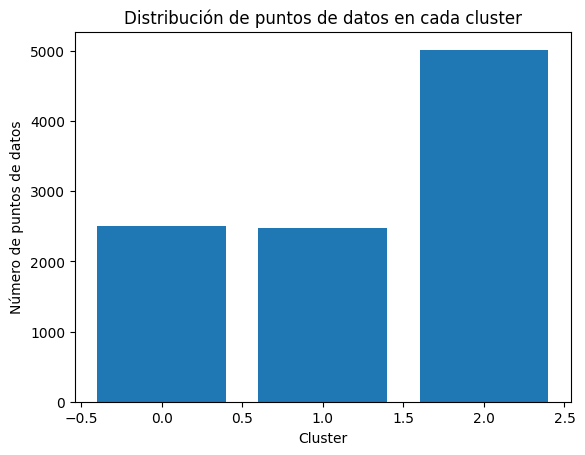

In [217]:
unique_labels, label_counts = np.unique(train_labels, return_counts=True)
print("Número de puntos de datos en cada cluster:")
for label, count in zip(unique_labels, label_counts):
    print(f"Cluster {label}: {count} puntos de datos")

# También puedes visualizar la distribución de las etiquetas
plt.bar(unique_labels, label_counts)
plt.xlabel('Cluster')
plt.ylabel('Número de puntos de datos')
plt.title('Distribución de puntos de datos en cada cluster')
plt.show()


##### Cluster 0

In [227]:
X = dict_cluster_dfs[0].drop(columns=['Exited'])
y = dict_cluster_dfs[0]['Exited']

X_train0, X_test0, y_train0, y_test0 = train_test_split(X, y, test_size=0.2, random_state=24)

# Aplicar RandomUnderSampler al conjunto de entrenamiento resampleado
smote = ADASYN(random_state=24)
X_train_resampled_clust0, y_train_resampled_clust0 = smote.fit_resample(X_train0, y_train0)

clust0_baseline = BaseLine(X_train_resampled_clust0, y_train_resampled_clust0, cv=5, metricas_cross_validate= ['accuracy', 'recall_macro', 'precision_macro']) # Input -> todos
clust0_baseline

Metrica,accuracy,precision,recall
Modelo,,,
ADABoosting,0.789610,0.791285,0.789591
CatBoost,0.834137,0.837610,0.834131
Decision Tree,0.759926,0.761478,0.759911
Extra Trees,0.729128,0.731191,0.729196
Gradient Boosting,0.816698,0.818571,0.816689
HistGradientBoost,0.821521,0.826113,0.821528
KNN,0.744341,0.759731,0.744564
LGBM,0.826716,0.832740,0.826698
Logistic Regression,0.678293,0.678562,0.678268


In [228]:
clust0_rf = RandomForestClassifier(n_estimators=500, max_depth=50, min_samples_split=2, min_samples_leaf=1, bootstrap=True, class_weight='balanced',  random_state=24)
clust0_rf.fit(X_train_resampled_clust0, y_train_resampled_clust0)

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       345
           1       0.66      0.66      0.66       157

    accuracy                           0.79       502
   macro avg       0.75      0.75      0.75       502
weighted avg       0.79      0.79      0.79       502



In [229]:
# # Guardar el modelo en un archivo
with open('./modelos/prof/clustersmodelos/clust0_rf.pkl', 'wb') as f:
    pickle.dump(clust0_rf, f)
    
# # # Cargar el modelo desde el archivo
with open('./modelos/prof/clustersmodelos/clust0_rf.pkl', 'rb') as f:
    loadedclust0 = pickle.load(f)

print(classification_report(y_test, loadedclust0.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       345
           1       0.66      0.66      0.66       157

    accuracy                           0.79       502
   macro avg       0.75      0.75      0.75       502
weighted avg       0.79      0.79      0.79       502



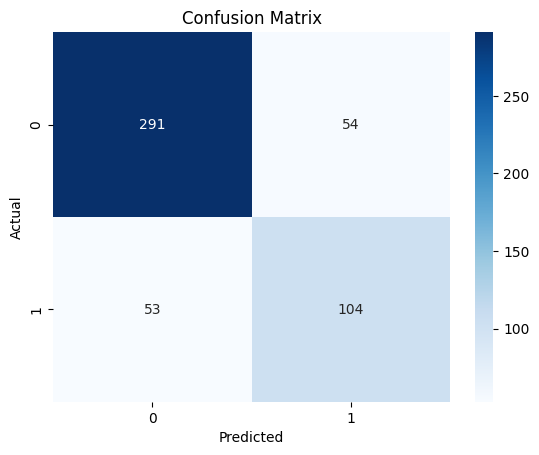

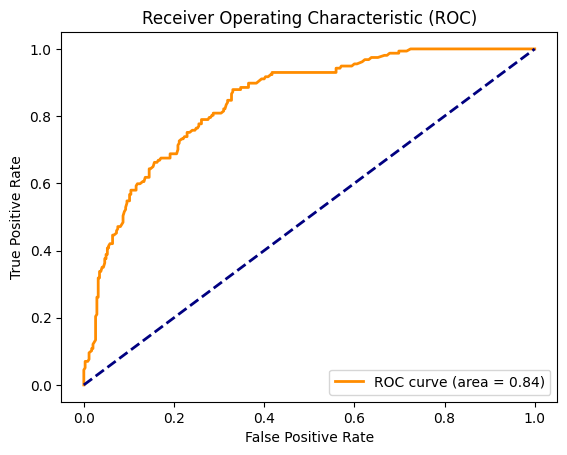

In [230]:
from sklearn.metrics import confusion_matrix,  roc_curve, auc
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, loadedclust0.predict(X_test))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Curva ROC
# Obtener las probabilidades de predicción en lugar de las predicciones directas
y_pred_proba = loadedclust0.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

La curva ROC es una representación gráfica del rendimiento de un modelo de clasificación en diferentes umbrales de clasificación. Tiene dos ejes: el eje X muestra la tasa de falsos positivos y el eje Y muestra la tasa de verdaderos positivos (también conocida como sensibilidad o recall).

- La línea diagonal representa el rendimiento de un clasificador aleatorio.

- La curva ROC del modelo se traza en el espacio ROC, y buscamos que esté lo más cerca posible del punto (0,1), que indica una tasa de verdaderos positivos del 100% y una tasa de falsos positivos del 0%.

- El área bajo la curva ROC (AUC) es una medida cuantitativa del rendimiento del modelo. Un AUC más cercano a 1 indica un mejor rendimiento del modelo, mientras que un AUC de 0.5 indica un rendimiento similar al de un clasificador aleatorio.

En resumen, al interpretar una curva ROC, buscamos un AUC alto, lo que indica un modelo con un buen rendimiento en la clasificación de las instancias.

************

##### Cluster 1

In [244]:
X = dict_cluster_dfs[1].drop(columns=['Exited'])
y = dict_cluster_dfs[1]['Exited']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=24)

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=24)
X_train_resampled_clust1, y_train_resampled_clust1 = smote.fit_resample(X_train1 , y_train1)

clust1_baseline = BaseLine(X_train_resampled_clust1, y_train_resampled_clust1, cv=5, metricas_cross_validate= ['accuracy', 'recall_macro', 'precision_macro']) # input -> todos
clust1_baseline

Metrica,accuracy,precision,recall
Modelo,,,
ADABoosting,0.811490,0.816510,0.811542
CatBoost,0.897707,0.914137,0.897790
Decision Tree,0.831817,0.834824,0.831855
Extra Trees,0.815726,0.816959,0.815742
Gradient Boosting,0.866737,0.880393,0.866816
HistGradientBoost,0.896796,0.913810,0.896880
KNN,0.838500,0.856813,0.838514
LGBM,0.896189,0.915761,0.896275
Logistic Regression,0.660595,0.660735,0.660594


In [245]:
clust1_cat = CatBoostClassifier(iterations= 200, silent=True, bagging_temperature = 10, learning_rate=0.1, eval_metric='Precision', auto_class_weights='Balanced')
clust1_cat.fit(X_train_resampled_clust1, y_train_resampled_clust1)

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       417
           1       0.64      0.54      0.59        79

    accuracy                           0.88       496
   macro avg       0.78      0.74      0.76       496
weighted avg       0.87      0.88      0.87       496



In [246]:
# Guardar el modelo en un archivo
with open('./modelos/prof/clustersmodelos/clust1_cat.pkl', 'wb') as f:
    pickle.dump(clust1_cat, f)
    
# # Cargar el modelo desde el archivo
with open('./modelos/prof/clustersmodelos/clust1_cat.pkl', 'rb') as f:
    loaded_clust1 = pickle.load(f)

print(classification_report(y_test, loaded_clust1.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84       345
           1       0.70      0.40      0.51       157

    accuracy                           0.76       502
   macro avg       0.74      0.66      0.68       502
weighted avg       0.75      0.76      0.74       502



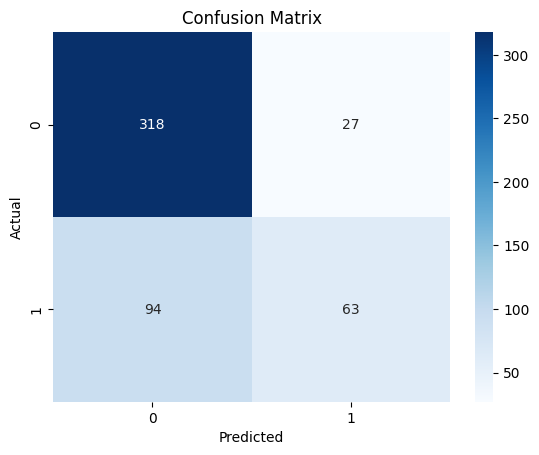

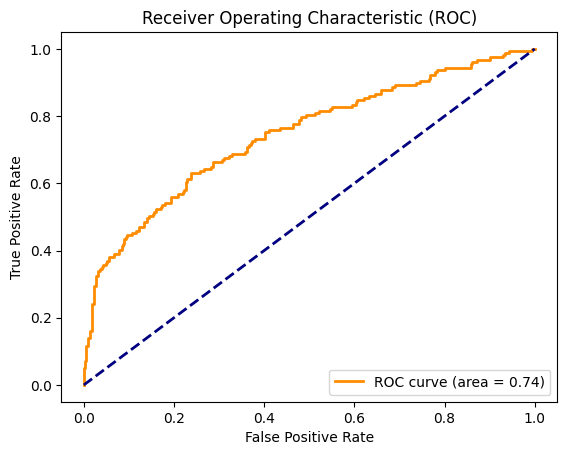

In [247]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, loaded_clust1.predict(X_test))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Curva ROC
y_pred_proba = loaded_clust1.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

****************

##### Cluster 2

In [256]:
X = dict_cluster_dfs[2].drop(columns=['Exited'])
y = dict_cluster_dfs[2]['Exited']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=24)

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=24)
X_train_resampled_clust2, y_train_resampled_clust2 = smote.fit_resample(X_train2 , y_train2)

clust2_baseline =  BaseLine(X_train_resampled_clust2, y_train_resampled_clust2, cv=5, metricas_cross_validate= ['accuracy','recall_macro', 'precision_macro'])
clust2_baseline

Metrica,accuracy,precision,recall
Modelo,,,
ADABoosting,0.830269,0.832995,0.830289
CatBoost,0.905855,0.926508,0.905901
Decision Tree,0.846784,0.854396,0.846814
Extra Trees,0.835469,0.836671,0.835473
Gradient Boosting,0.873416,0.883112,0.873448
HistGradientBoost,0.901241,0.918665,0.901284
KNN,0.865666,0.880011,0.865666
LGBM,0.902138,0.924785,0.902187
Logistic Regression,0.709315,0.709476,0.709316


In [257]:
clus2_cat = CatBoostClassifier(bagging_temperature = 10, iterations = 300 , bootstrap_type= 'MVS', silent=True, learning_rate=0.1, eval_metric='Precision',  auto_class_weights='Balanced')
clus2_cat.fit(X_train_resampled_clust2, y_train_resampled_clust2)

In [258]:
# # Guardar el modelo en un archivo
with open('./modelos/prof/clustersmodelos/clus2_cat.pkl', 'wb') as f:
    pickle.dump(clus2_cat, f)
    
# # # Cargar el modelo desde el archivo
with open('./modelos/prof/clustersmodelos/clus2_cat.pkl', 'rb') as f:
    loaded_clust2= pickle.load(f)

print(classification_report(y_test, loaded_clust2.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.79      0.94      0.86       345
           1       0.76      0.45      0.57       157

    accuracy                           0.78       502
   macro avg       0.78      0.69      0.71       502
weighted avg       0.78      0.78      0.77       502



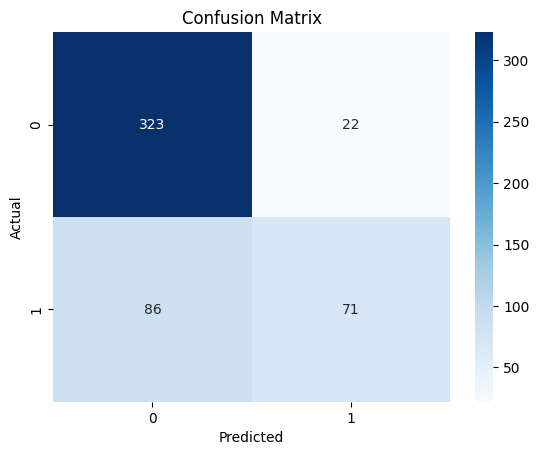

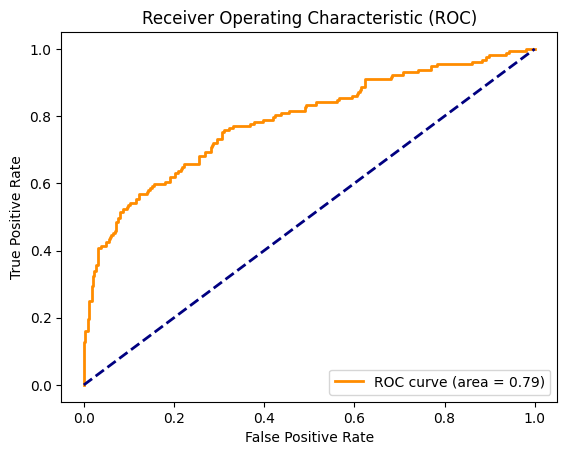

In [259]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test,  loaded_clust2.predict(X_test))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Curva ROC
y_pred_proba = loaded_clust2.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### Modelo 7
**Aplicaremos la cluesterización manual por Geography**

In [260]:
df = pd.read_csv('./data/processed/Churn_Modelling.csv')

df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

df_france = df[df['Geography'] == 'France']
df_spain = df[df['Geography'] == 'Spain']
df_germany = df[df['Geography'] == 'Germany']


<Axes: xlabel='Geography', ylabel='Count'>

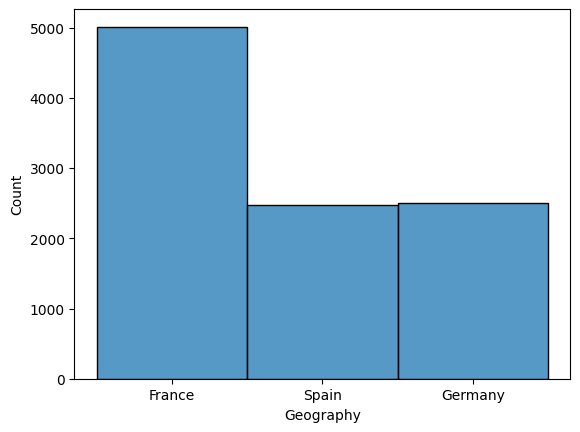

In [261]:
sns.histplot(df['Geography'])

##### df_france

In [283]:
df_france['CreditCardOwnerTenure'] = df_france.HasCrCard * df_france.Age
df_france['Balance_Tenure_Ratio'] = df_france['Balance'] / (df_france['Tenure'] + 1e-6)

# Definir las variables X e y
X = df_france.drop(columns=['Exited']) 
y = df_france['Exited']

numeric_features = ['CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'Balance', 'Balance_Tenure_Ratio', 'CreditCardOwnerTenure' ]
categ = ['Gender']

# Definir transformadores para características numéricas y categóricas
numeric_transformer = MinMaxScaler()

# Crear un ColumnTransformer para aplicar transformaciones a diferentes columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)

# Crear el pipeline con el preprocesador
pipeline = make_pipeline(preprocessor)

X_processed = pipeline.fit_transform(X)

# Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df = pd.DataFrame(X_processed, columns=numeric_features)
concatenated_series  = pd.concat((processed_df, X[['IsActiveMember', 'Gender']].reset_index(drop=True)), axis=1)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(concatenated_series, y, test_size=0.2, random_state=24)

# # Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTENC(random_state=24, categorical_features= categ)
X_train_resampled_france, y_train_resampled_france = smote.fit_resample(X_train, y_train) 

In [284]:
france_model = CatBoostClassifier(silent=True, iterations= 500, bootstrap_type = 'MVS', bagging_temperature= 10, eval_metric='Precision', learning_rate=0.01)
france_model.fit(X_train_resampled_france, y_train_resampled_france, cat_features=categ)

In [285]:
df_best = pd.DataFrame({'Columna' : concatenated_series.columns, 'Importances' : france_model.feature_importances_})
df_best.sort_values(by='Importances', ascending=False)

,Columna,Importances
3,NumOfProducts,27.105183
1,Age,25.007016
2,Tenure,23.153677
7,IsActiveMember,6.431414
4,Balance,4.623166
8,Gender,3.975285
6,CreditCardOwnerTenure,3.703173
5,Balance_Tenure_Ratio,3.692051
0,CreditScore,2.309036


In [286]:
# Mostrar el reporte de clasificación
print("Reporte de clasificación para Francia:")
print(classification_report(y_test, france_model.predict(X_test)))

Reporte de clasificación para Francia:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       843
           1       0.49      0.67      0.57       160

    accuracy                           0.84      1003
   macro avg       0.71      0.77      0.73      1003
weighted avg       0.86      0.84      0.85      1003



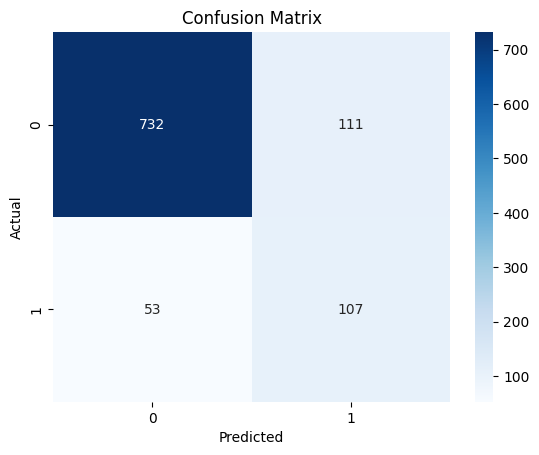

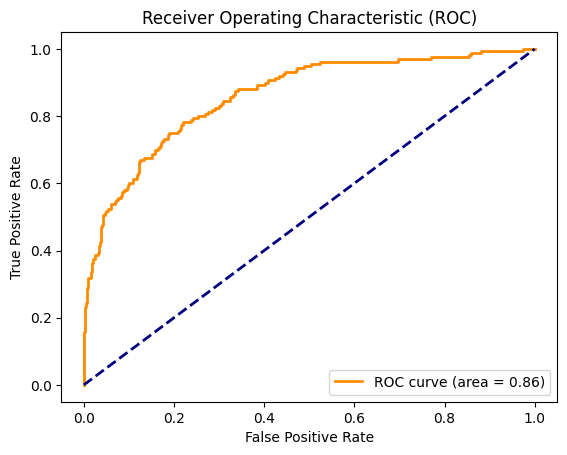

In [288]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test,  france_model.predict(X_test))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Curva ROC
y_probs = france_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [289]:
# Obtener las probabilidades de predicción para la clase positiva
y_probs = france_model.predict_proba(X_test)[:, 1]
# Calcular la precisión, el recall y los umbrales utilizando precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
# # Calcular el F1-score para cada umbral
f1_scores = 2 * (precision * recall) / (precision + recall)
# # Encontrar el índice del umbral que maximiza el F1-score
best_threshold_index = f1_scores.argmax()

# # Seleccionar el umbral óptimo
optimal_threshold = thresholds[best_threshold_index]
y_pred_optimal = (y_probs >= optimal_threshold).astype(int)

print("Reporte de clasificación para Francia:")
print(classification_report(y_test, y_pred_optimal))


Reporte de clasificación para Francia:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       843
           1       0.69      0.51      0.58       160

    accuracy                           0.89      1003
   macro avg       0.80      0.73      0.76      1003
weighted avg       0.88      0.89      0.88      1003



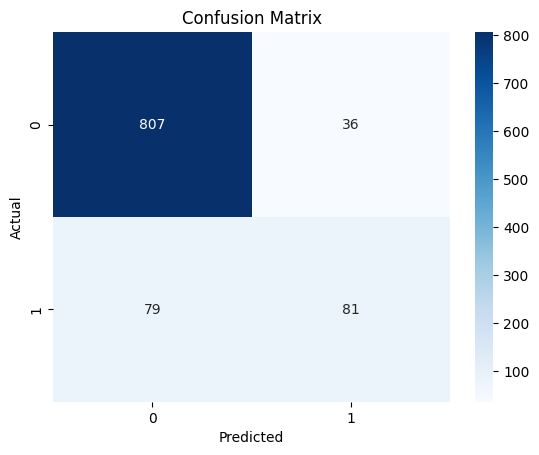

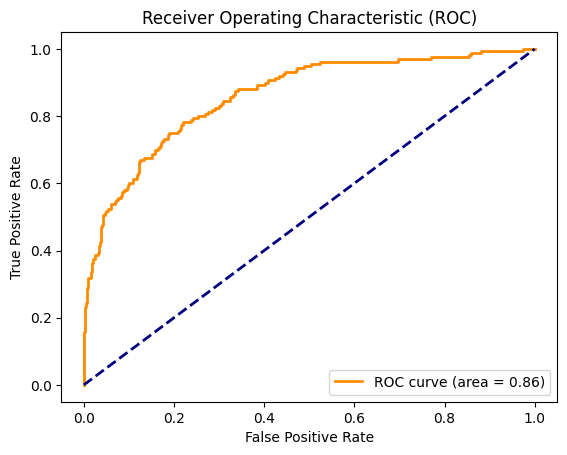

In [290]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_optimal)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

**********

##### df_spain

In [300]:
df_spain['CreditCardOwnerTenure'] = df_spain.HasCrCard * df_spain.Age
df_spain['Saldo_Salario_Ratio'] = df_spain['Balance'] / df_spain['EstimatedSalary']
df_spain['is_male'] = df_spain['Gender'].replace({'Female' : 0 , 'Male': 1})

numeric_features = ['Age', 'Tenure', 'Balance', 'NumOfProducts', 'CreditCardOwnerTenure', 'Saldo_Salario_Ratio']
variables_sin_modificacion = ['HasCrCard', 'IsActiveMember', 'Exited', 'is_male']

# Definir transformadores para características numéricas y categóricas
numeric_transformer = MinMaxScaler()

# Crear un ColumnTransformer para aplicar transformaciones a diferentes columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)

# Crear el pipeline con el preprocesador
pipeline = make_pipeline(preprocessor)
# Aplicar el preprocesador a los datos
X_processed = pipeline.fit_transform(df_spain)

# # Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df_spain = pd.DataFrame(X_processed, columns=numeric_features)
concatenated_series_spain  = pd.concat((processed_df_spain, df_spain[['IsActiveMember', 'Exited', 'is_male']].reset_index(drop=True)), axis=1)

X = concatenated_series_spain.drop(columns='Exited')
y = concatenated_series_spain['Exited']

# # # Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# # # Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=24)
X_train_resampled_spain, y_train_resampled_spain = smote.fit_resample(X_train , y_train)

# spain_baseline = BaseLine(X_train_resampled_spain, y_train_resampled_spain, cv=5, metricas_cross_validate= ['accuracy', 'precision_macro', 'recall_macro']) # input -> todos
spain_baseline

Metrica,accuracy,precision,recall
Modelo,,,
ADABoosting,0.808459,0.811920,0.808493
CatBoost,0.899835,0.917236,0.899920
Decision Tree,0.830913,0.833135,0.830936
Extra Trees,0.839112,0.840231,0.839116
Gradient Boosting,0.863708,0.874648,0.863781
HistGradientBoost,0.896494,0.912957,0.896582
KNN,0.847609,0.861566,0.847603
LGBM,0.898923,0.918878,0.899015
Logistic Regression,0.656952,0.657170,0.656943


In [296]:
spain_model_cat = CatBoostClassifier(silent=True, iterations= 500, bootstrap_type = 'MVS', bagging_temperature= 10, eval_metric='Precision', learning_rate=0.01)
spain_model_cat.fit(X_train_resampled_spain, y_train_resampled_spain)

In [297]:
df_best = pd.DataFrame({'Columna' : X.columns, 'Importances' : spain_model_cat.feature_importances_})
df_best.sort_values(by='Importances', ascending=False)

,Columna,Importances
3,NumOfProducts,36.370498
1,Tenure,24.175276
0,Age,13.995997
2,Balance,8.833857
6,IsActiveMember,6.879279
5,Saldo_Salario_Ratio,3.767195
4,CreditCardOwnerTenure,3.179896
7,is_male,2.798000


In [298]:
print("Reporte de clasificación para España:")
print(classification_report(y_test, spain_model_cat.predict(X_test)))

Reporte de clasificación para España:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       417
           1       0.54      0.65      0.59        79

    accuracy                           0.85       496
   macro avg       0.73      0.77      0.75       496
weighted avg       0.87      0.85      0.86       496



In [301]:
model_spain = lgb.LGBMClassifier(verbosity= -1, num_leaves=50, learning_rate=0.05,  min_child_samples=20, max_depth=40, is_unbalance=True, min_split_gain=0.1)
model_spain.fit(X_train_resampled_spain, y_train_resampled_spain)

print(classification_report(y_test, model_spain.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       417
           1       0.53      0.49      0.51        79

    accuracy                           0.85       496
   macro avg       0.72      0.70      0.71       496
weighted avg       0.84      0.85      0.85       496



In [9]:
# # # Guardar el modelo en un archivo
with open('./modelos/prof/paises/spain_lgb.pkl', 'wb') as f:
    pickle.dump(spain_model_cat, f)
    
# # Cargar el modelo desde el archivo
with open('./modelos/prof/paises/spain_lgb.pkl', 'rb') as f:
    loaded_spain = pickle.load(f)

print(classification_report(y_test, loaded_spain.predict(X_test) ))
print('Los mejores hiperparametros obtenidos son:', loaded_spain.best_params_)

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       417
           1       0.61      0.49      0.55        79

    accuracy                           0.87       496
   macro avg       0.76      0.72      0.73       496
weighted avg       0.86      0.87      0.86       496

Los mejores hiperparametros obtenidos son: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 300, 'reg_alpha': 0.01}


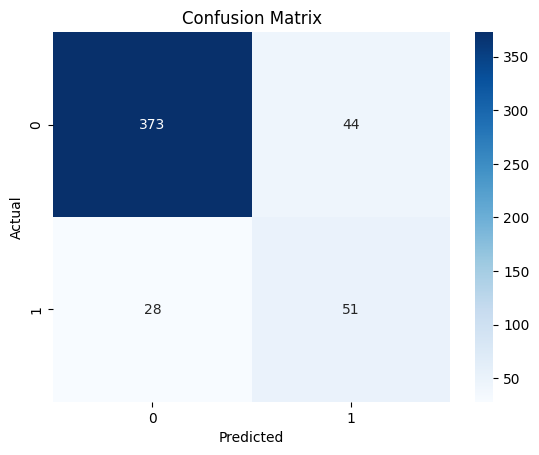

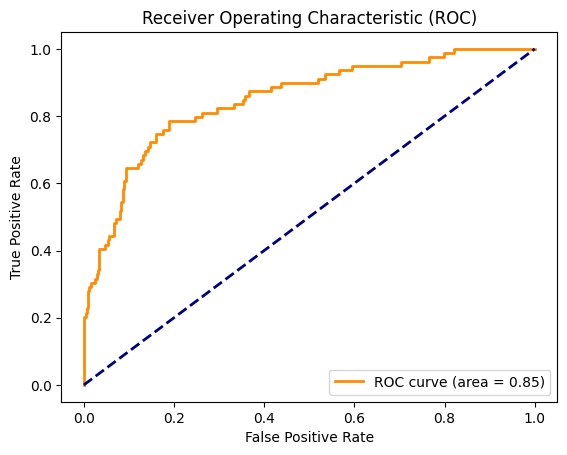

In [302]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test,  spain_model_cat.predict(X_test))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Curva ROC
y_pred_proba = spain_model_cat.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

*******************

##### df_german

In [306]:
df_germany['CreditCardOwnerTenure'] = df_germany.HasCrCard * df_germany.Age
df_germany['Saldo_Salario_Ratio'] = df_germany['Balance'] / df_germany['EstimatedSalary']
df_germany['is_male'] = df_germany['Gender'].replace({'Female' : 0, 'Male' : 1})

X = df_germany.drop(columns=['Exited', 'Gender'])
y = df_germany['Exited']

numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'Saldo_Salario_Ratio', 'CreditCardOwnerTenure' ]
variables_sin_modificacion =  df_germany[['IsActiveMember', 'is_male']]

# Definir transformadores para características numéricas y categóricas
numeric_transformer = MinMaxScaler()

# Crear un ColumnTransformer para aplicar transformaciones a diferentes columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)
# Crear el pipeline con el preprocesador
pipeline = make_pipeline(preprocessor)
# Aplicar el preprocesador a los datos
X_processed = pipeline.fit_transform(X)

# Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df = pd.DataFrame(X_processed, columns=numeric_features)
concatenated_series_germany  = pd.concat([processed_df, variables_sin_modificacion.reset_index(drop=True) ], axis=1) #

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(concatenated_series_germany, y, test_size=0.2, random_state=24)

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=24)
X_train_resampled_germany, y_train_resampled_germany = smote.fit_resample(X_train, y_train)

germany_baseline = BaseLine(X_train_resampled_germany, y_train_resampled_germany, cv=5, metricas_cross_validate= ['accuracy', 'recall_macro', 'precision_macro'])
germany_baseline

Metrica,accuracy,precision,recall
Modelo,,,
ADABoosting,0.791481,0.793367,0.791481
CatBoost,0.830370,0.833281,0.830370
Decision Tree,0.764444,0.767296,0.764444
Extra Trees,0.762963,0.765008,0.762963
Gradient Boosting,0.818148,0.820026,0.818148
HistGradientBoost,0.824815,0.828319,0.824815
KNN,0.783333,0.789885,0.783333
LGBM,0.828519,0.832218,0.828519
Logistic Regression,0.681852,0.682245,0.681852


In [307]:
model_german = CatBoostClassifier(silent=True, iterations= 300, bagging_temperature= 10, eval_metric='Recall', learning_rate=0.05)
model_german.fit(X_train_resampled_germany, y_train_resampled_germany)

print(classification_report(y_test, model_german.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84       345
           1       0.64      0.66      0.65       157

    accuracy                           0.78       502
   macro avg       0.74      0.74      0.74       502
weighted avg       0.78      0.78      0.78       502



In [309]:
df_best = pd.DataFrame({'Columna' : concatenated_series_germany.columns, 'Importances' : model_german.feature_importances_})
df_best.sort_values(by='Importances', ascending=False)

,Columna,Importances
4,NumOfProducts,19.237004
2,Tenure,19.123230
1,Age,16.884984
3,Balance,13.882719
0,CreditScore,8.866784
5,Saldo_Salario_Ratio,8.125984
7,IsActiveMember,5.737476
6,CreditCardOwnerTenure,4.490230
8,is_male,3.651590


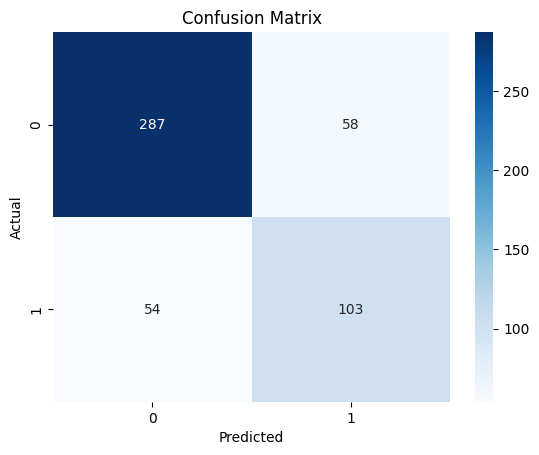

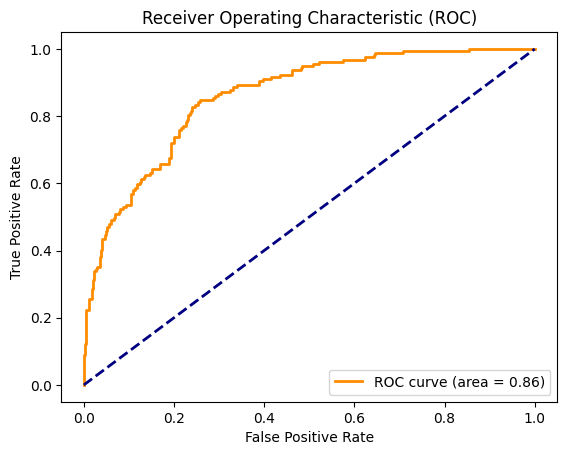

In [310]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test,  model_german.predict(X_test))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Curva ROC
y_pred_proba = model_german.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [311]:
y_probs = model_german.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold_index = f1_scores.argmax()

# Seleccionar el umbral óptimo
optimal_threshold_german = thresholds[best_threshold_index]
y_pred_optimal = (y_probs >= optimal_threshold_german).astype(int)

print("Reporte de clasificación para Germany:")
print(classification_report(y_test, y_pred_optimal))

Reporte de clasificación para Germany:
              precision    recall  f1-score   support

           0       0.91      0.76      0.83       345
           1       0.61      0.83      0.70       157

    accuracy                           0.78       502
   macro avg       0.76      0.79      0.76       502
weighted avg       0.81      0.78      0.79       502



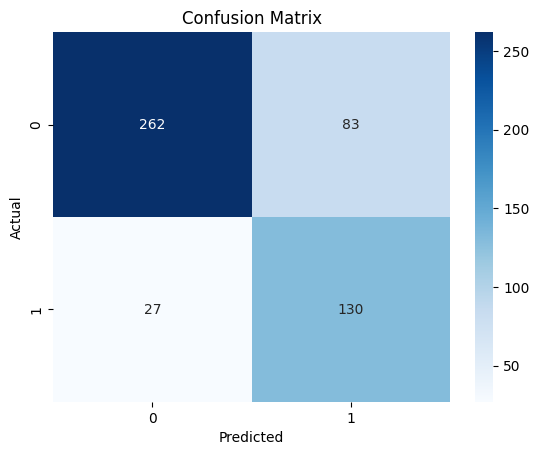

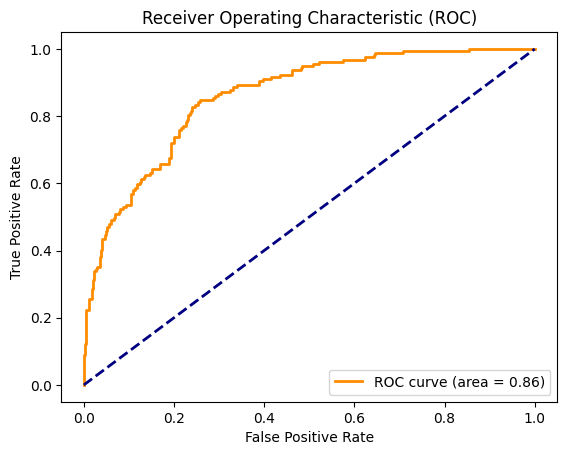

In [312]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_optimal)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### Modelo 8

**Redes neuronales**

In [361]:
df = pd.read_csv('./data/processed/Churn_Modelling.csv')

df['CreditCardOwnerTenure'] = df.HasCrCard * df.Age
df['Balance_Tenure_Ratio'] = df['Balance'] / (df['Tenure'] + 1e-6)
df['is_male'] = df['Gender'].replace({'Female' : 0, 'Male': 1})

df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Gender'], inplace=True)

# Definir las variables X e y
X = df.drop(columns=['Exited'])
y = df['Exited']

numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'CreditCardOwnerTenure', 'Balance_Tenure_Ratio' ]
categorical_features = ['Geography']

# Definir transformadores para características numéricas y categóricas
numeric_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder()

# Crear un ColumnTransformer para aplicar transformaciones a diferentes columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Crear el pipeline con el preprocesador
pipeline = make_pipeline(preprocessor)
# Aplicar el preprocesador a los datos
X_processed = pipeline.fit_transform(X)

# Obtener los nombres de las columnas después de aplicar OneHotEncoder
encoded_categorical_columns = preprocessor.named_transformers_['cat']\
    .get_feature_names_out(input_features=categorical_features)

# Combinar los nombres de las columnas numéricas y categóricas
processed_columns = numeric_features + list(encoded_categorical_columns)

# Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df = pd.DataFrame(X_processed, columns=processed_columns)
concatenated_series  = pd.concat((processed_df, X[[ 'HasCrCard', 'is_male', 'IsActiveMember']]), axis=1)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(concatenated_series, y, test_size=0.2, random_state=24)

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = ADASYN(random_state=24)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [362]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers , regularizers

# Define las capas del modelo
capas = [
    keras.layers.Dense(units=150, activation='relu', input_shape=(X_train_resampled.shape[1],) , kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dense(units=100, activation='relu'),
    keras.layers.Dense(units=40, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid')
]

model = keras.models.Sequential(capas)

# Compila el modelo
model.compile(
    optimizer='sgd',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Summary del modelo
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 150)               2100      
                                                                 
 dense_34 (Dense)            (None, 100)               15100     
                                                                 
 dense_35 (Dense)            (None, 40)                4040      
                                                                 
 dense_36 (Dense)            (None, 1)                 41        
                                                                 
Total params: 21,281
Trainable params: 21,281
Non-trainable params: 0
_________________________________________________________________


In [363]:
from tensorflow.keras.callbacks import EarlyStopping

# Definir EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo con EarlyStopping
history = model.fit(
    X_train_resampled,
    y_train_resampled,
    batch_size=30,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/50


343/343 [==============================] - 11s 15ms/step - loss: 0.8836 - accuracy: 0.6069 - val_loss: 1.1385 - val_accuracy: 0.0000e+00
Epoch 2/50
343/343 [==============================] - 5s 14ms/step - loss: 0.8327 - accuracy: 0.6291 - val_loss: 1.1154 - val_accuracy: 0.0762
Epoch 3/50
343/343 [==============================] - 5s 14ms/step - loss: 0.7943 - accuracy: 0.6467 - val_loss: 1.0579 - val_accuracy: 0.2007
Epoch 4/50
343/343 [==============================] - 4s 12ms/step - loss: 0.7625 - accuracy: 0.6622 - val_loss: 1.0753 - val_accuracy: 0.2314
Epoch 5/50
343/343 [==============================] - 4s 11ms/step - loss: 0.7351 - accuracy: 0.6779 - val_loss: 1.0306 - val_accuracy: 0.3088
Epoch 6/50
343/343 [==============================] - 4s 13ms/step - loss: 0.7117 - accuracy: 0.6852 - val_loss: 1.0010 - val_accuracy: 0.3524
Epoch 7/50
343/343 [==============================] - 4s 11ms/step - loss: 0.6911 - accuracy: 0.6885 - val_loss: 1.0129 - val_accuracy: 0.3403
Epoch

In [364]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.883577,0.606945,1.138496,0.000000
1,0.832712,0.629122,1.115355,0.076235
2,0.794272,0.646727,1.057943,0.200700
3,0.762524,0.662192,1.075270,0.231427
4,0.735130,0.677950,1.030576,0.308829
5,0.711702,0.685245,1.000980,0.352392
6,0.691061,0.688454,1.012874,0.340335
7,0.673605,0.693123,0.978748,0.385064
8,0.658657,0.696528,1.006184,0.362505
9,0.647661,0.697403,0.933805,0.416958


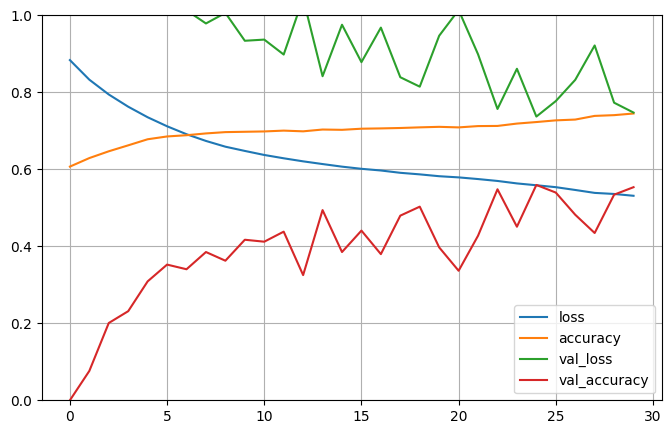

In [365]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [366]:
results = model.evaluate(X_test, y_test)
results

63/63 [==============================] - 1s 9ms/step - loss: 0.5047 - accuracy: 0.7750


[0.5047302842140198, 0.7749999761581421]